In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [51]:
import sys
import scipy

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)
    
print("TensorFlow v" + tf.__version__)

Environment specification:

python 3.11.5
numpy 1.24.3
scipy 1.15.0
seaborn 0.12.2
sklearn 1.3.0
pandas 2.0.3
TensorFlow v2.15.0


In [52]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [53]:
print('Environment specification:\n')
for mod in sklearn, xgb, lgb:
    print(mod.__name__, mod.__version__)

Environment specification:

sklearn 1.3.0
xgboost 2.1.3
lightgbm 4.5.0


### 1. 缺失值处理
* missing_data_detection
* impute_na 处理空值，可以按照fill_value去填充
* fill_na_by_group

### 2. 异常值处理
remove_outliers(dataset, threshold=3, columns=None, removed=False)
- dataset: 输入的 Pandas DataFrame
- threshold: Z-Score 阈值（默认 3）
- columns: 指定需要检测的列（默认对所有数值列）
- removed: 是否返回被移除的异常值

### 3. 偏度处理
* skew_processing, exclude_columns: 不需要处理的列列表

### 4. Encoding
* identify_column_types, 看哪些column是numerical，哪些column是string
* dummy_encode
* encode_column_with_ordinal

### 5. 单变量分布可视化
* diagnostic_plots

### 6. 缺失值可视化
6.1 检测缺失值比例，绘制柱状图展示缺失比例高的特征。
missing_data_detection(data)

### 7. Cross validation plotting
* diagnostic_plots

In [54]:
def missing_data_detection(data):
    col_nan = (data.isna().sum() / data.shape[0]).sort_values(ascending=False)
    col_nan_filtered = col_nan[col_nan > 0.01]
    plt.figure(figsize=(8, 5))
    sns.set(font_scale=1.2)
    col_nan_filtered.plot(kind="barh", color="skyblue")
    plt.title("Features with the Highest Percentage of NaN Values (Sorted)")
    plt.xlabel("Percentage of Missing Values")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

def impute_na(data, columns, strategy, fill_value=None): #strategy: mean, median, most_frequent
    if strategy == 'constant' and fill_value is None:
        raise ValueError("When strategy is 'constant', fill_value must be provided.")
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy, fill_value=fill_value)
    for column in columns:
        data[[column]] = imputer.fit_transform(data[[column]])
    return data

def fill_na_by_group(data, target_column, groupby_column, func='median'):
    if isinstance(func, str):
        if func == 'median':
            filler = lambda x: x.fillna(x.median())
        elif func == 'mean':
            filler = lambda x: x.fillna(x.mean())
        else:
            raise ValueError("Unsupported func. Use 'median', 'mean'.")
    elif callable(func):
        filler = lambda x: x.fillna(func(x))
    else:
        raise ValueError("func must be a callable.")

    data[target_column] = data.groupby(groupby_column)[target_column].transform(filler)
    return data
    
def remove_outliers(dataset, threshold=5, columns=None, method='drop'):
    if columns is None:
        columns = dataset.select_dtypes(include=['number']).columns
    else:
        numeric_columns = dataset.select_dtypes(include=['number']).columns
        columns = [col for col in columns if col in numeric_columns]
        if not columns:
            raise ValueError("No valid numeric columns specified.")

    tmp = dataset.copy()

    z_scores = np.abs(stats.zscore(tmp[columns]))

    if method == 'drop':
        non_outlier_mask = (z_scores < threshold).all(axis=1)
        print(f"Number of removed rows: {len(tmp) - non_outlier_mask.sum()}")
        return tmp[non_outlier_mask]
    elif method == 'clip':
        for col in columns:
            col_mean = tmp[col].mean()
            col_std = tmp[col].std()
            lower_limit = col_mean - threshold * col_std
            upper_limit = col_mean + threshold * col_std
            tmp[col] = np.clip(tmp[col], lower_limit, upper_limit)
        print("Outliers have been clipped to the specified threshold.")
        return tmp
    else:
        raise ValueError("Method must be either 'drop' or 'clip'.")
    
def skew_processing(all_data, exclude_columns=None):
    """
    Process skewed numeric features with Box-Cox transformation.
    """
    if exclude_columns is None:
        exclude_columns = []

    num_features = all_data.select_dtypes(include=['int64', 'float64']).columns
    
    numeric_features = [feat for feat in num_features if feat not in exclude_columns]

    # selecting columns with skew more than 0.5
    skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
    skewed_features = skewed_features[skewed_features > 0.5].index
    print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))
    
    lambda_ = 0.15
    for feature in skewed_features:
        all_data[feature] = boxcox1p(all_data[feature], lambda_)
        
    return all_data

def identify_column_types(df):
    column_types = {
        'numeric': [],
        'string': []}

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            column_types['numeric'].append(col)
        elif pd.api.types.is_string_dtype(df[col]):
            column_types['string'].append(col)
    return column_types

#result = identify_column_types(df)
#print("Numeric columns:", result['numeric'])
#print("String columns:", result['string'])

def dummy_encode(data, column):
    dummy_data = pd.get_dummies(data[column], drop_first=True, prefix=column)
    data = pd.concat([data, dummy_data], axis=1)
    data = data.drop(columns=[column])  # Drop the original column after encoding
    return data

######################################################
# perform ordinal encoding on the 'feature' column
#df['feature_map'] = df['feature'].map(the_map)

from sklearn.preprocessing import OrdinalEncoder

def encode_column_with_ordinal(data, column): 
    encoder = OrdinalEncoder()
    encoded_values = encoder.fit_transform(data[[column]])
    data[column] = encoded_values
    return data

def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))
    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()


def plot_cross_val_scores(estimator, X, y, scoring='r2', cv=5, param_name=None, param_values=None):
    if scoring == 'rmse':
        scorer = make_scorer(mean_squared_error, squared=False)  # RMSE
        score_label = 'RMSE'
    elif scoring == 'r2':
        scorer = make_scorer(r2_score)  # R^2
        score_label = 'R^2'
    else:
        raise ValueError("Unsupported scoring method. Use 'rmse' or 'r2'.")

    if param_name and param_values:
        scores = []
        for param_value in param_values:
            # Dynamically set the parameter value for the estimator
            estimator.set_params(**{param_name: param_value})
            # Perform cross-validation
            cv_scores = cross_val_score(estimator, X, y, cv=cv, scoring=scorer)
            scores.append(np.mean(cv_scores))
        
        # Plot the cross-validation scores
        plt.figure(figsize=(8, 5))
        plt.plot(param_values, scores, marker='o', label=f'Cross-Validation {score_label}')
        plt.title(f'Cross-Validation Scores vs {param_name}')
        plt.xlabel(param_name)
        plt.ylabel(score_label)
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        # If no hyperparameter is specified, plot the cross-validation scores for the model as is
        cv_scores = cross_val_score(estimator, X, y, cv=cv, scoring=scorer)
        print(f"Cross-Validation {score_label} Scores: {cv_scores}")
        print(f"Mean {score_label}: {np.mean(cv_scores):.4f}")

In [55]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor

def ols_regression(X_train, y_train, X_test, y_test, loss_type='normal'):
    # Scale the features and target using RobustScaler
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    if loss_type == 'normal':
        final_model = LinearRegression()
    elif loss_type == 'huber':
        final_model = HuberRegressor()
    else:
        raise ValueError("Unsupported loss type. Choose 'normal' or 'huber'.")

    final_model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = final_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_test, y_pred)
    print("Test", r2)

    return y_pred, r2, final_model

# y_pred, r2, model = ols_regression(X_train, y_train, X_test, y_test, loss_type='normal')
# y_pred_huber, r2_huber, model_huber = ols_regression(X_train, y_train, X_test, y_test, loss_type='huber')


In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler

def lasso_regression(X_train, y_train, X_test, y_test, alpha_values, cv=5, X_val=None, y_val=None):
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    if X_val is not None and y_val is not None:
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

        best_alpha = None
        best_r2 = -np.inf

        for alpha in alpha_values:
            lasso_model = Lasso(alpha=alpha)
            lasso_model.fit(X_train_scaled, y_train_scaled)
            val_r2 = lasso_model.score(X_val_scaled, y_val_scaled)

            if val_r2 > best_r2:
                best_r2 = val_r2
                best_alpha = alpha

        print(f"Best alpha (validation set): {best_alpha}")
        print(f"Best validation R^2: {best_r2:.4f}")

    else:
        # Tune alpha using cross-validation
        best_alpha = None
        best_r2 = -np.inf

        for alpha in alpha_values:
            lasso_model = Lasso(alpha=alpha)
            cv_scores = cross_val_score(lasso_model, X_train_scaled, y_train_scaled, cv=cv, scoring='r2')
            mean_r2 = np.mean(cv_scores)

            if mean_r2 > best_r2:
                best_r2 = mean_r2
                best_alpha = alpha

        print(f"Best alpha (cross-validation): {best_alpha}")
        print(f"Test R2: {best_r2:.4f}")

    final_model = Lasso(alpha=best_alpha)
    final_model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = final_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = final_model.score(X_test_scaled, y_test_scaled)

    return best_alpha, y_pred, r2, final_model

In [57]:
def elastic_net_regression(X_train, y_train, X_test, y_test, l2_ratios, l1_ratios, cv=4, X_val=None, y_val=None):
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    if X_val is not None and y_val is not None:
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

        best_params = None
        best_r2 = -np.inf

        for l2_ratio in l2_ratios:
            for l1_ratio in l1_ratios:
                en_model = ElasticNet(alpha=l2_ratio, l1_ratio=l1_ratio, random_state=42)
                en_model.fit(X_train_scaled, y_train_scaled)
                val_r2 = en_model.score(X_val_scaled, y_val_scaled)

                if val_r2 > best_r2:
                    best_r2 = val_r2
                    best_params = {"l2_ratio": l2_ratio, "l1_ratio": l1_ratio}

        print(f"Best parameters (validation set): {best_params}")
        print(f"Best validation R^2: {best_r2:.4f}")

    else:
        # Use GridSearchCV for cross-validation tuning
        param_grid = {
            'alpha': l2_ratios,
            'l1_ratio': l1_ratios
        }
        grid_search = GridSearchCV(
            ElasticNet(random_state=42),
            param_grid,
            cv=cv,
            scoring='r2',
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train_scaled)

        best_params = {
            "l2_ratio": grid_search.best_params_["alpha"],
            "l1_ratio": grid_search.best_params_["l1_ratio"]
        }
        best_r2 = grid_search.best_score_

        print(f"Best parameters (cross-validation): {best_params}")
        print(f"Best cross-validated R^2: {best_r2:.4f}")

    final_model = ElasticNet(alpha=best_params["l2_ratio"], l1_ratio=best_params["l1_ratio"], random_state=42)
    final_model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = final_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_test, y_pred)
    print(f"Test R^2: {r2:.4f}")

    return best_params, y_pred, r2, final_model

In [58]:
'''
l2_ratios = [0.1, 0.01, 0.001]
l1_ratios = [0.1, 0.5, 0.9]

best_params, y_pred, r2, EN_model = elastic_net_regression(
    X_train, y_train, X_test, y_test,
    l2_ratios=l2_ratios, l1_ratios=l1_ratios, cv=5)

print("Best Parameters:", best_params)
print("Test R^2:", r2)
'''

'\nl2_ratios = [0.1, 0.01, 0.001]\nl1_ratios = [0.1, 0.5, 0.9]\n\nbest_params, y_pred, r2, EN_model = elastic_net_regression(\n    X_train, y_train, X_test, y_test,\n    l2_ratios=l2_ratios, l1_ratios=l1_ratios, cv=5)\n\nprint("Best Parameters:", best_params)\nprint("Test R^2:", r2)\n'

In [59]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def random_forest_regression(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=None):
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    # Scale the features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Train the Random Forest model with specified parameters
    final_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    final_model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = final_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    r2 = r2_score(y_test, y_pred)

    return y_pred, r2, final_model

In [60]:
'''
y_pred_rf, r2_rf, model_rf = random_forest_regression(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=5)
'''

'\ny_pred_rf, r2_rf, model_rf = random_forest_regression(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=5)\n'

In [61]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

def lgbm_regression(X_train, y_train, X_test, y_test, param_grid, cv=5, scaler_type='RobustScaler'):
    if scaler_type == 'RobustScaler':
        scaler_X = RobustScaler()
    elif scaler_type == 'StandardScaler':
        scaler_X = StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_X = MinMaxScaler()
    else:
        raise ValueError("Unsupported scaler type. Choose from 'RobustScaler', 'StandardScaler', or 'MinMaxScaler'.")

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Use GridSearchCV for cross-validation tuning
    grid_search = GridSearchCV(
        LGBMRegressor(random_state=42),
        param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    best_r2 = grid_search.best_score_

    print(f"Best parameters (cross-validation): {best_params}")
    print(f"Best cross-validated R^2: {best_r2:.4f}")

    # Train the model with the best parameters on the entire training set
    final_model = LGBMRegressor(
        **best_params,
        random_state=42)
    final_model.fit(X_train_scaled, y_train)

    y_pred = final_model.predict(X_test_scaled)
    r2 = final_model.score(X_test_scaled, y_test)

    return best_params, y_pred, r2, final_model

In [62]:
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)): #can cv = 3 to make it faster
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    if ylim is not None:
        plt.ylim(*ylim)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Car Price prediction

In [63]:
car_data = pd.read_csv("train/train.csv")

In [64]:
car_data

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


In [65]:
car_data["model_year"].max()

2024

In [66]:
car_data["car_year"] = car_data["model_year"].max() - car_data["model_year"]

In [67]:
del car_data["id"]

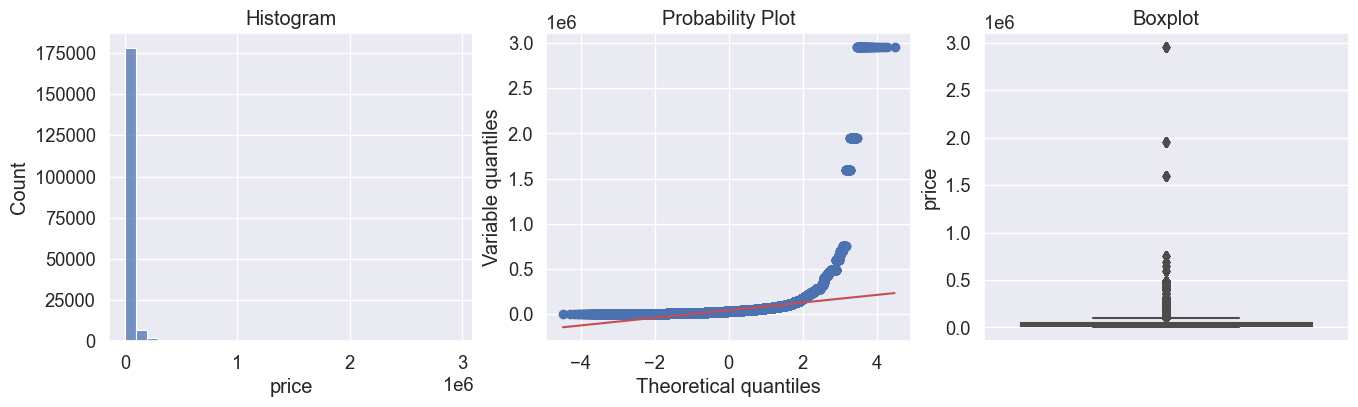

In [68]:
diagnostic_plots(car_data, "price")

In [69]:
car_data = skew_processing(car_data)


Highly skewed features: 

['milage', 'price', 'car_year']


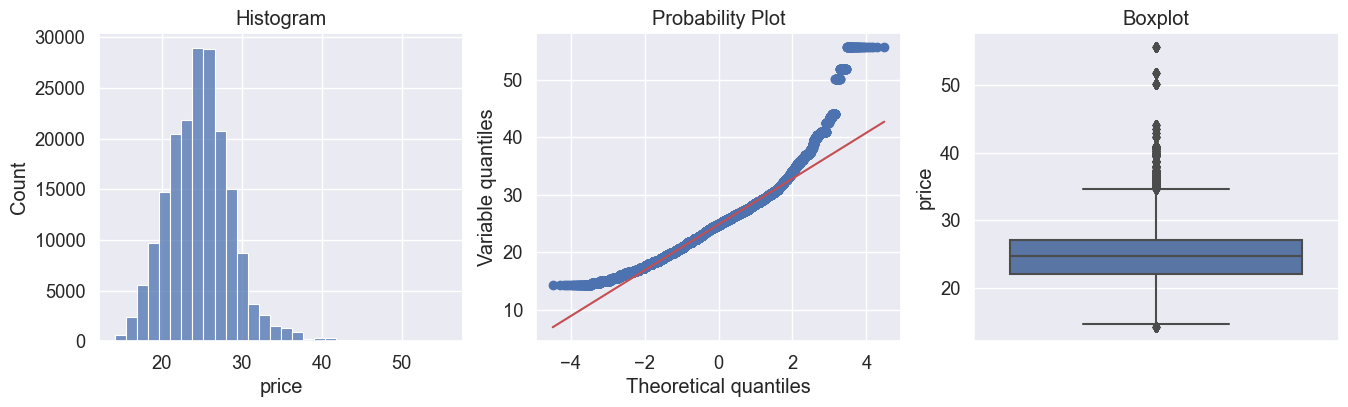

In [70]:
diagnostic_plots(car_data, "price")

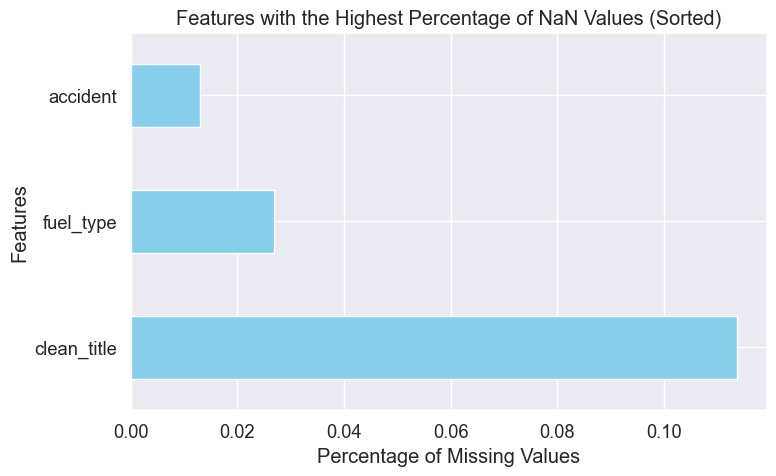

In [71]:
missing_data_detection(car_data)

In [72]:
car_data["clean_title"].unique()

array(['Yes', nan], dtype=object)

In [73]:
car_data["fuel_type"].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [74]:
car_data["accident"].unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

In [75]:
tmp = remove_outliers(car_data, threshold=3, method='clip')

Outliers have been clipped to the specified threshold.


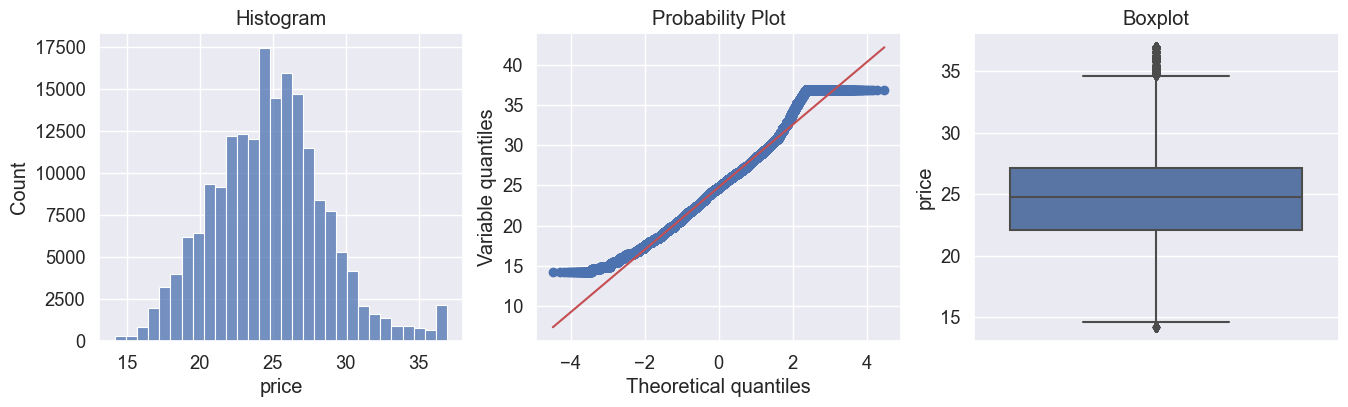

In [76]:
diagnostic_plots(tmp, "price")

In [77]:
car_data["clean_title"] = car_data["clean_title"].fillna("No")
car_data["accident"] = car_data["accident"].fillna("Unkown")
car_data["fuel_type"] = car_data["fuel_type"].fillna("Unknown")

In [78]:
car_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'car_year'],
      dtype='object')

In [79]:
car_data = dummy_encode(car_data,"brand")

In [80]:
car_data["transmission"].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [81]:
car_data = car_data.drop(columns=["model_year","engine"])

In [82]:
car_data = dummy_encode(car_data,"fuel_type")

In [83]:
car_data = dummy_encode(car_data, "transmission")

In [84]:
car_data = dummy_encode(car_data, "ext_col")

In [85]:
car_data = dummy_encode(car_data, "clean_title")

In [86]:
car_data = dummy_encode(car_data, "accident")

In [87]:
len(car_data.columns)

440

In [88]:
car_data = car_data.drop(columns = "int_col")

In [89]:
car_data.columns

Index(['model', 'milage', 'price', 'car_year', 'brand_Alfa', 'brand_Aston',
       'brand_Audi', 'brand_BMW', 'brand_Bentley', 'brand_Bugatti',
       ...
       'ext_col_Yellow', 'ext_col_Yulong', 'ext_col_Yulong White',
       'ext_col_designo Diamond White', 'ext_col_designo Diamond White Bright',
       'ext_col_designo Diamond White Metallic', 'ext_col_–',
       'clean_title_Yes', 'accident_None reported', 'accident_Unkown'],
      dtype='object', length=439)

In [90]:
y = car_data["price"]
X = car_data.drop(columns=['price','model'])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
y_pred, r2, model = ols_regression(X_train, y_train, X_test, y_test, loss_type='huber')

Test 0.5601044405836317


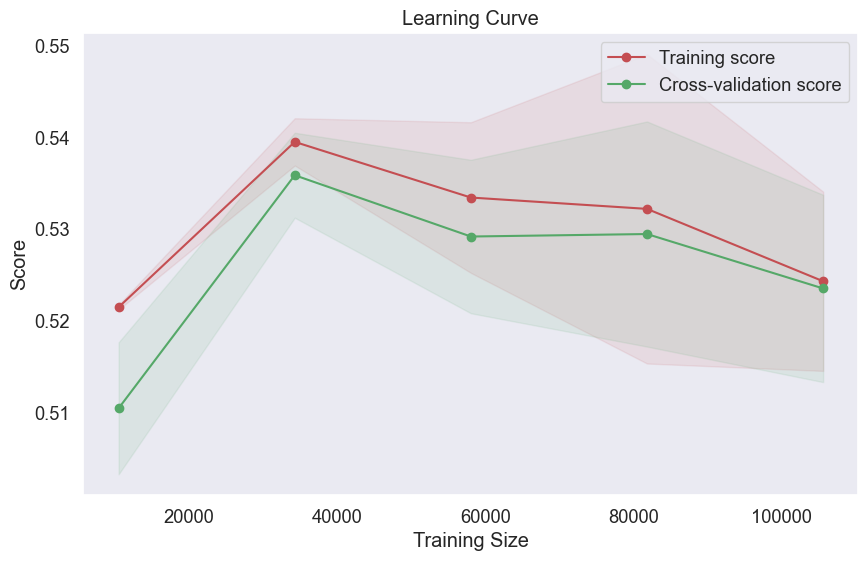

In [93]:
plot_learning_curve(model, X_train, y_train)

In [94]:
l2_ratios = [0.1, 0.01, 0.001]
l1_ratios = [0.1, 0.5, 0.9]

best_params, y_pred, r2, EN_model = elastic_net_regression(
    X_train, y_train, X_test, y_test,
    l2_ratios=l2_ratios, l1_ratios=l1_ratios, cv=5
)

print("Best Parameters:", best_params)
print("Test R^2:", r2)

Best parameters (cross-validation): {'l2_ratio': 0.001, 'l1_ratio': 0.1}
Best cross-validated R^2: 0.5639
Test R^2: 0.5593
Best Parameters: {'l2_ratio': 0.001, 'l1_ratio': 0.1}
Test R^2: 0.5593081602209334


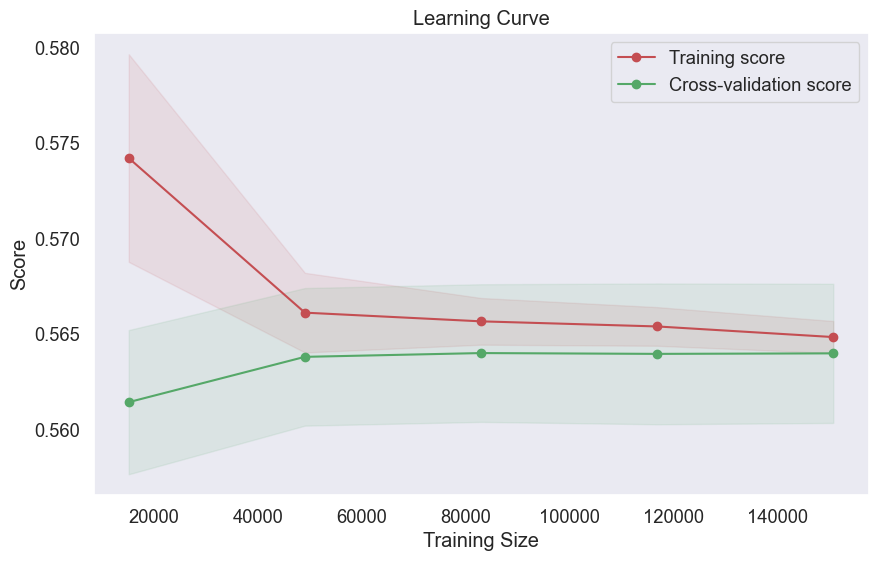

In [95]:
plot_learning_curve(EN_model, X, y)

In [96]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [97]:
best_params, y_pred, r2, lgbm_model = lgbm_regression(
    X_train, y_train, X_test, y_test,
    param_grid=param_grid,
    cv=5,
    scaler_type='RobustScaler'
)
print("Best Parameters:", best_params)
print("R^2 on Test Set:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 131973, number of used features: 294
[LightGBM] [Info] Start training from score 24.794761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

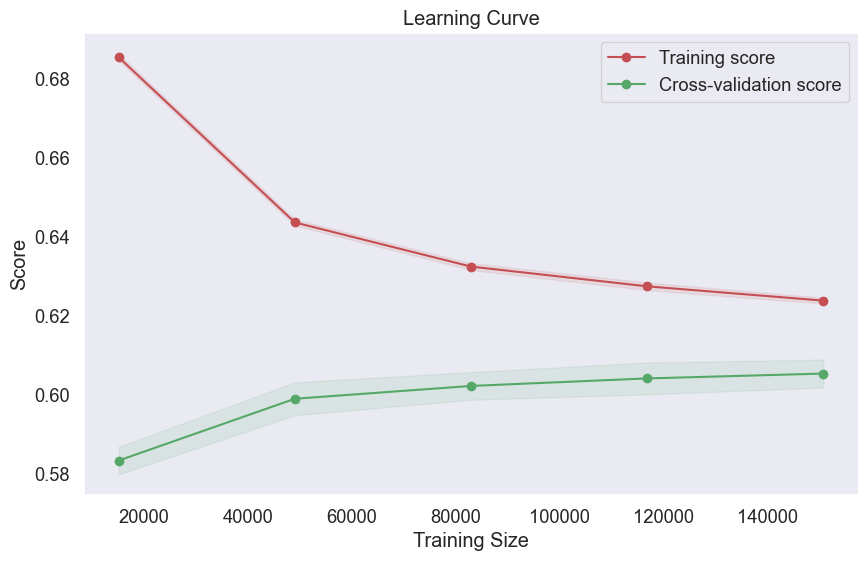

In [98]:
plot_learning_curve(lgbm_model, X, y)

In [99]:
y_pred_rf, r2_rf, model_rf = random_forest_regression(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=5)

print("Test R^2:", r2)

Test R^2: 0.6020452685492468


In [47]:
from sklearn.svm import SVR

def svr_regression(X_train, y_train, X_test, y_test, param_grid, cv=5, scaler_type='RobustScaler'):
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    # Scale the features and target
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Use GridSearchCV for cross-validation tuning
    grid_search = GridSearchCV(
        SVR(),
        param_grid,
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train_scaled)

    best_params = grid_search.best_params_
    best_r2 = grid_search.best_score_

    print(f"Best parameters (cross-validation): {best_params}")
    print(f"Best cross-validated R^2: {best_r2:.4f}")

    # Train the model with the best parameters on the entire training set
    final_model = SVR(**best_params)
    final_model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = final_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    r2 = r2_score(y_test, y_pred)

    return best_params, y_pred, r2, final_model

In [ ]:
# Example usage for SVR:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1]
}
best_params, y_pred_svr, r2_svr, model_svr = svr_regression(X_train, y_train, X_test, y_test, param_grid, cv=5, scaler_type='StandardScaler')

In [ ]:
plot_learning_curve(model_svr, X, y)

In [ ]:
from itertools import product

def single_param_tune_and_plot(estimator, X_train, y_train, param_grid, scoring='r2', cv=5):
    if len(param_grid) == 1:
        # Single parameter tuning: plot results
        param_name = list(param_grid.keys())[0]
        param_values = param_grid[param_name]
        scores = []

        for param_value in param_values:
            estimator.set_params(**{param_name: param_value})
            cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring=scoring)
            scores.append(np.mean(cv_scores))

        # Plot the cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.plot(param_values, scores, marker='o', label='Cross-Validation Scores')
        plt.title(f'Cross-Validation Scores vs {param_name}')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.grid(True)
        plt.legend()
        plt.show()

        # Find the best parameter and refit the model
        best_param = param_values[np.argmax(scores)]
        estimator.set_params(**{param_name: best_param})
        estimator.fit(X_train, y_train)

        print(f"Best {param_name}: {best_param}")
        print(f"Best cross-validation score: {max(scores):.4f}")

        return estimator, {param_name: best_param}, scores
    else:
        # Multiple parameter tuning: grid search without plotting
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())

        best_score = -np.inf
        best_params = None

        # Iterate through all combinations of parameter values
        for param_combination in product(*param_values):
            params = dict(zip(param_names, param_combination))
            estimator.set_params(**params)

            # Perform cross-validation
            cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring=scoring)
            mean_score = np.mean(cv_scores)

            if mean_score > best_score:
                best_score = mean_score
                best_params = params

        # Refit the model with the best parameters
        estimator.set_params(**best_params)
        estimator.fit(X_train, y_train)

        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score:.4f}")

        return estimator, best_params, None

# House Price

### 1. drop outlier, missing data, feature scaling/normalization, in sample v.s. out sample

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas

In [6]:
# kaggle train data
train_df = pd.read_csv("./House-Prices-Advanced-Regression-Techniques-master\House-Prices-Advanced-Regression-Techniques-master/dane/train.csv")
# kaggle test data
test_df = pd.read_csv("./House-Prices-Advanced-Regression-Techniques-master\House-Prices-Advanced-Regression-Techniques-master/dane/test.csv")

In [7]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [8]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y_train = train_df["SalePrice"]

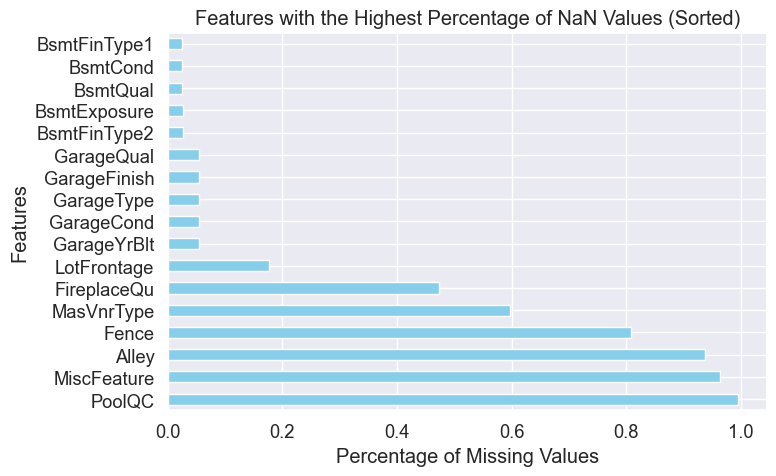

In [9]:
missing_data_detection(train_df)

In [10]:
# Dropping columns for both train and test dataset
train_df = train_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

train_df = train_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

# clear_data is a dataframe with train data after removing outliers

In [11]:
clear_data = train_df.drop(train_df[(train_df['GrLivArea']>4500)].index)
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_df, test_df]).reset_index(drop=True)

In [12]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [13]:
all_data.loc[2592, 'GarageYrBlt'] = 2007

In [14]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [15]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

In [16]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [17]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [18]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [19]:
# Generating numerical features as input to DataFrameMapper.  
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


In [20]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [21]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

In [22]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

In [23]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

# Applying the "none_transform" function 
all_data = none_transform(all_data, none_conversion)

In [24]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [25]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

In [26]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [27]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [28]:
all_data

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,BsmtFinType1,Exterior1st,SaleCondition,OverallCond,GarageType,GarageFinish,SaleType,LandContour,MasVnrType,RoofMatl
0,65.0,8450.0,7.0,2003.0,2003.0,150.0,856.0,856.0,854.0,0.0,...,GLQ,VinylSd,Normal,5,Attchd,RFn,WD,Lvl,BrkFace,CompShg
1,80.0,9600.0,6.0,1976.0,1976.0,284.0,1262.0,1262.0,0.0,0.0,...,ALQ,MetalSd,Normal,8,Attchd,RFn,WD,Lvl,None,CompShg
2,68.0,11250.0,7.0,2001.0,2002.0,434.0,920.0,920.0,866.0,0.0,...,GLQ,VinylSd,Normal,5,Attchd,RFn,WD,Lvl,BrkFace,CompShg
3,60.0,9550.0,7.0,1915.0,1970.0,540.0,756.0,961.0,756.0,0.0,...,ALQ,Wd Sdng,Abnorml,5,Detchd,Unf,WD,Lvl,None,CompShg
4,84.0,14260.0,8.0,2000.0,2000.0,490.0,1145.0,1145.0,1053.0,0.0,...,GLQ,VinylSd,Normal,5,Attchd,RFn,WD,Lvl,BrkFace,CompShg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,1936.0,4.0,1970.0,1970.0,546.0,546.0,546.0,546.0,0.0,...,Unf,CemntBd,Normal,7,No,No,WD,Lvl,None,CompShg
2915,21.0,1894.0,4.0,1970.0,1970.0,294.0,546.0,546.0,546.0,0.0,...,Rec,CemntBd,Abnorml,5,CarPort,Unf,WD,Lvl,None,CompShg
2916,160.0,20000.0,5.0,1960.0,1996.0,0.0,1224.0,1224.0,0.0,0.0,...,ALQ,VinylSd,Abnorml,7,Detchd,Unf,WD,Lvl,None,CompShg
2917,62.0,10441.0,5.0,1992.0,1992.0,575.0,912.0,970.0,0.0,0.0,...,GLQ,HdBoard,Normal,5,No,No,WD,Lvl,None,CompShg


In [29]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

# If the house has a garage
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a fireplace
all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a pool
all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has second floor
all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Open Porch
all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Wood Deck
all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

In [30]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 324)

In [31]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

In [32]:
train_preprocessed = all_data.iloc[:len(train_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


In [33]:
X_train = train_preprocessed

In [34]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, n_jobs=-1))
    return(np.mean(rmse_score))

In [37]:
lr_model = make_pipeline(RobustScaler(), LinearRegression()) 

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))
print(r2_score(y_train_pred, y_train))

Mean Squared Error = 0.00858436
RMSE score for Linear Regression: 30732.238
0.9430994650954478


In [38]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))
print(r2_score(y_train_pred, y_train))

Mean Squared Error = 0.01197439
RMSE score for LASSO: 0.135
0.916305243730673


In [39]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [62]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))
print(r2_score(y_train_pred, y_train))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000976
RMSE score for GB: 0.123
0.9999386823763886


In [53]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00050283
RMSE score for XGB: 0.118


In [54]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)

In [55]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

In [56]:
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.01171991
RMSE score for ElasticNet: 0.136


In [57]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_wei